## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_2606-0207-2023.csv', firstRow=636, lastRow=642)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_110723_S637-642.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=64s and ended at t=500s; mass=43.974599999999995g
This equals a volume of 44.063m; expected was 44.334mL; error is 0.612%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


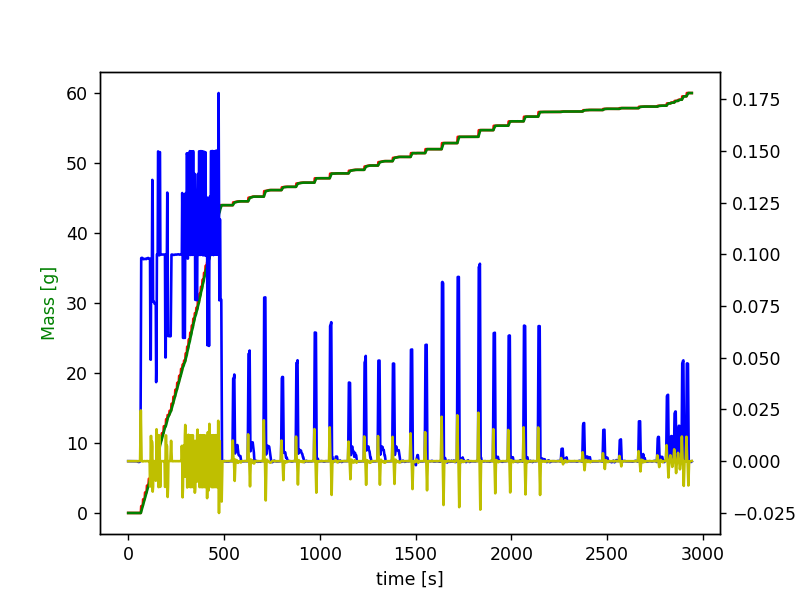

Addition of 0.554g Plantapon LC 7 detected from 542s to 594s - expected volume = 0.613mL and actual volume = 0.524mL (resulting error is 14.491%)
Addition of 0.67g Plantapon LC 7 detected from 622s to 664s - expected volume = 0.613mL and actual volume = 0.634mL (resulting error is 3.441%)
Addition of 0.939g Plantapon LC 7 detected from 704s to 750s - expected volume = 0.942mL and actual volume = 0.88mL (resulting error is 6.597%)
Addition of 0.468g Plantacare 2000 detected from 796s to 834s - expected volume = 0.511mL and actual volume = 0.428mL (resulting error is 16.24%)
Addition of 0.601g Plantacare 2000 detected from 872s to 922s - expected volume = 0.511mL and actual volume = 0.55mL (resulting error is 7.574%)
Addition of 0.633g Dehyton PK 45 detected from 968s to 996s - expected volume = 0.616mL and actual volume = 0.605mL (resulting error is 1.677%)
Addition of 0.692g Dehyton PK 45 detected from 1048s to 1098s - expected volume = 0.616mL and actual volume = 0.661mL (resulting er

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.000328125 g/s^2


<IPython.core.display.Javascript object>


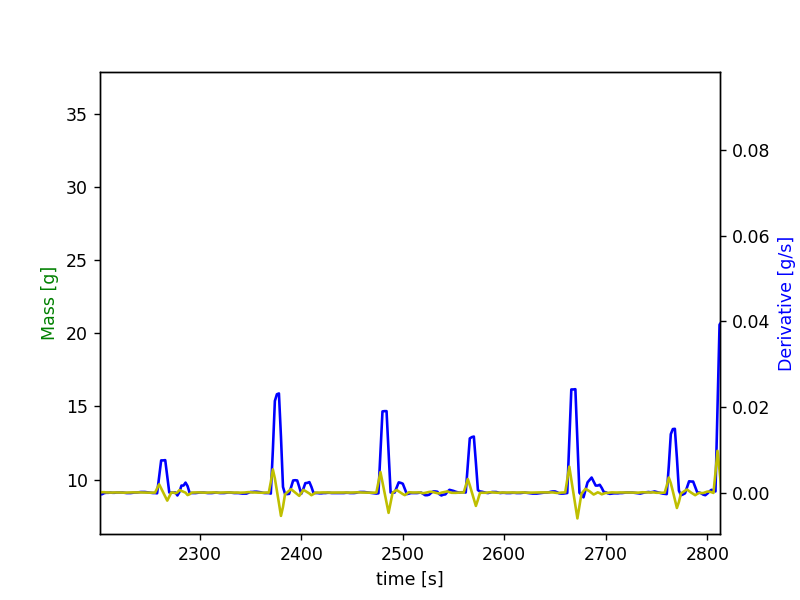

Addition of 0.072g Salcare Super 7 detected from 2256s to 2294s - expected volume = 0.105mL and actual volume = 0.064mL (resulting error is 38.889%)
Addition of 0.219g Salcare Super 7 detected from 2368s to 2416s - expected volume = 0.228mL and actual volume = 0.198mL (resulting error is 13.439%)
Addition of 0.166g Salcare Super 7 detected from 2474s to 2506s - expected volume = 0.132mL and actual volume = 0.151mL (resulting error is 14.041%)
Addition of 0.106g Salcare Super 7 detected from 2560s to 2578s - expected volume = 0.09mL and actual volume = 0.095mL (resulting error is 5.875%)
Addition of 0.224g Salcare Super 7 detected from 2660s to 2700s - expected volume = 0.213mL and actual volume = 0.201mL (resulting error is 6.067%)
Addition of 0.132g Salcare Super 7 detected from 2758s to 2794s - expected volume = 0.092mL and actual volume = 0.118mL (resulting error is 28.155%)


In [5]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=7, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


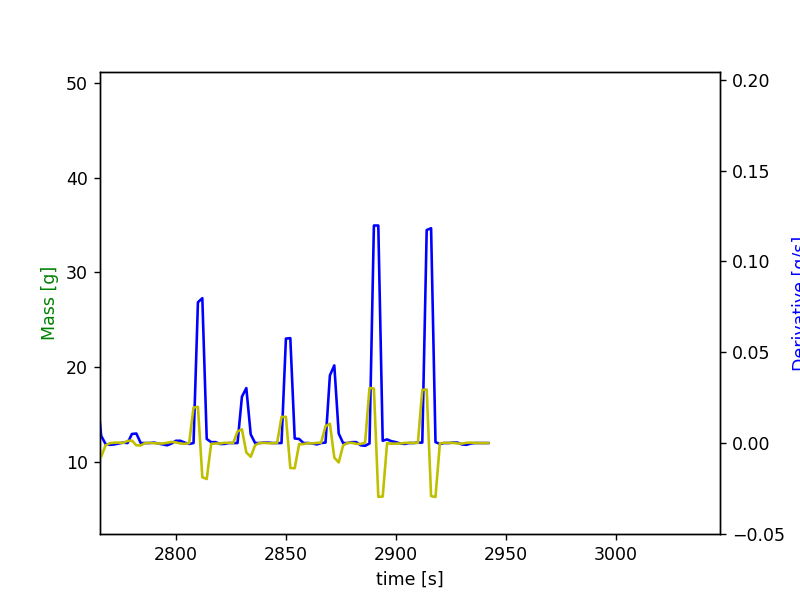

Addition of 0.321g Arlypon F detected from 2806s to 2818s - expected volume = 0.359mL and actual volume = 0.365mL (resulting error is 1.424%)
Addition of 0.121g Arlypon F detected from 2826s to 2840s - expected volume = 0.119mL and actual volume = 0.139mL (resulting error is 16.827%)
Addition of 0.24g Arlypon F detected from 2846s to 2858s - expected volume = 0.26mL and actual volume = 0.275mL (resulting error is 5.727%)
Addition of 0.17g Arlypon F detected from 2866s to 2880s - expected volume = 0.175mL and actual volume = 0.194mL (resulting error is 10.714%)
Addition of 0.481g Arlypon F detected from 2886s to 2898s - expected volume = 0.535mL and actual volume = 0.543mL (resulting error is 1.582%)
Addition of 0.472g Arlypon F detected from 2910s to 2922s - expected volume = 0.51mL and actual volume = 0.534mL (resulting error is 4.656%)


In [6]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2600,2616,2636,2656,2676,2884,2906])

## Consolidate results and create output

In [7]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_110723_S637-S642.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_27720\2712525937.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
636,637.0,0.0,0.0,0.000000,0.0,10.687707,0.0,0.000000,0.000000,0.000000,0.0,9.542524,0.0,0.0,0.0,0.0,0.715114,3.205512,0.0
637,638.0,0.0,0.0,12.140425,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,12.558855,0.0,0.0,0.0,0.0,2.171474,1.204722,0.0
638,639.0,0.0,0.0,0.000000,0.0,0.000000,0.0,13.206104,11.242927,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.659234,2.391688,0.0
639,640.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,12.075812,10.831436,0.0,0.000000,0.0,0.0,0.0,0.0,1.033320,1.664047,0.0
640,641.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,8.675748,0.0,13.324459,0.0,0.0,0.0,0.0,2.222393,4.766513,0.0
641,642.0,0.0,0.0,9.329043,0.0,0.000000,0.0,0.000000,0.000000,8.991142,0.0,0.000000,0.0,0.0,0.0,0.0,1.311850,4.690858,0.0
